# **Library**

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3e251ea0cfac565475bdeed2e8091ec0f65890f2bae87d5b54cb1fb294a76e93
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# import library
import pandas as pd
import csv
import numpy as np
import nltk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

#from datasets import load_metric
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
import regex as re

# explainable
import lime
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# **Dataset**

In [ ]:
!gdown --id 1OBK82ho8ihU8ce_0lIqDES-yR30BVZsu #dataset clean 2

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OBK82ho8ihU8ce_0lIqDES-yR30BVZsu
To: /content/dataset_clean2.xlsx
100% 68.0k/68.0k [00:00<00:00, 60.5MB/s]


In [ ]:
# download dataset
df = pd.read_excel('dataset_clean2.xlsx')

In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.head(5)

narasi-berita  label
0   yang rela anak jadi magneto junior follow follow      1
1  siap siap ppkm level segera laku desember pent...      1
2  ingat mulai oktober pasien covid tanggung keme...      1
3  sinetron bajay bajuri thn sdh mau thn nyata ja...      1
4  bintang bollywood amir khan sempat hujat hanya...      1

In [ ]:
df['label'].value_counts()

0    249
1    243
Name: label, dtype: int64

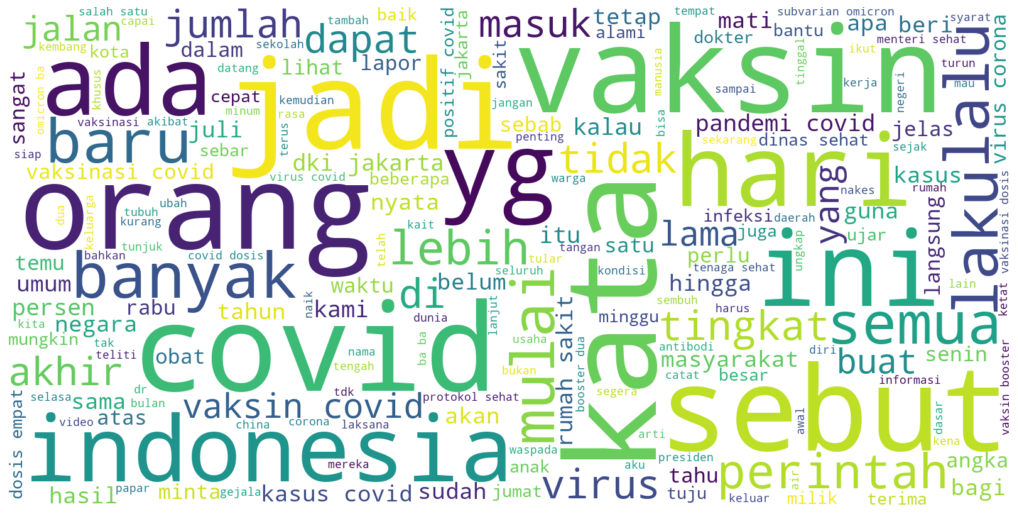

In [ ]:
from wordcloud import WordCloud

text = " ".join(cat for cat in df['narasi-berita'])
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white').generate(text)
# Display the generated Word Cloud
plt.figure(figsize=(18,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Data Splitting**

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data = df['narasi-berita']
tokenize = []
for t in data:
    word_tokens = word_tokenize(t)
    tokenize.append(word_tokens)

In [ ]:
train_text = [' '.join(sent) for sent in tokenize]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000)

feature_vec = vectorizer.fit_transform(train_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(feature_vec)
X_train_tf = tf_transformer.transform(feature_vec)
X_train_tf.shape

(492, 4151)

In [ ]:
train_data = train_text
train_labels = df['label']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_data,train_labels,test_size=0.2,random_state=0)

In [ ]:
# Melihat ukuran data latih dan data uji
print('X_train : ', len(X_train))
print('X_test : ', len(X_test))


X_train :  393
X_test :  99


# **TF-IDF**

In [ ]:
from sklearn.pipeline import Pipeline

text_features = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

text_features.fit_transform(X_train)

<393x3699 sparse matrix of type '<class 'numpy.float64'>'
	with 15331 stored elements in Compressed Sparse Row format>

# **Model Training**

## **SVM**

In [ ]:
pipe = Pipeline([
    ('features', text_features),
    ('svc', svm.SVC(C=100, kernel='rbf', gamma=0.001, probability=True)),
])

pipe.fit(X_train, y_train)

svm_pred = pipe.predict(X_test)
svm_probs = pipe.predict_proba(X_test)

# Menggunakan metrics accuracy untuk melihat performa model
print("Accuracy score: " + str(accuracy_score(y_test, svm_pred)))
print("Log loss: " + str(log_loss(y_test, svm_probs)));

Accuracy score: 0.9090909090909091
Log loss: 0.18898716209901908


### **Evaluasi**

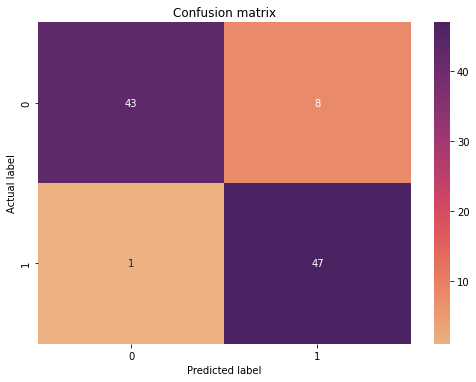

Accuracy: 90.9090909090909%
Precission: 85.45454545454545%
Recall: 97.91666666666666%


In [ ]:
# memvisualisasikan confusion matrix dengan heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(f"Accuracy: {metrics.accuracy_score(y_test, svm_pred)*100}%")
print(f"Precission: {metrics.precision_score(y_test, svm_pred)*100}%")
print(f"Recall: {metrics.recall_score(y_test, svm_pred)*100}%")

In [ ]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91        51
           1       0.85      0.98      0.91        48

    accuracy                           0.91        99
   macro avg       0.92      0.91      0.91        99
weighted avg       0.92      0.91      0.91        99



## **LogReg**

In [ ]:
pipe2 = Pipeline([
    ('features', text_features),
    ('lor', LogisticRegression()),
])

pipe2.fit(X_train, y_train)

logreg_pred = pipe2.predict(X_test)
logreg_probs = pipe2.predict_proba(X_test)

# Menggunakan metrics accuracy untuk melihat performa model
print("Accuracy score: " + str(accuracy_score(y_test, logreg_pred)))
print("Log loss: " + str(log_loss(y_test, logreg_probs)));

Accuracy score: 0.9292929292929293
Log loss: 0.40950035952926545


### **Evaluasi**

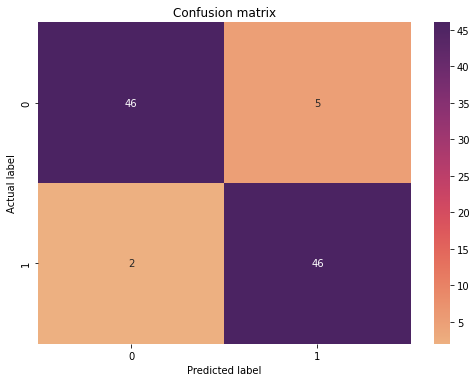

Accuracy: 92.92929292929293%
Precission: 90.19607843137256%
Recall: 95.83333333333334%


In [ ]:
# memvisualisasikan confusion matrix dengan heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, logreg_pred), annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(f"Accuracy: {metrics.accuracy_score(y_test, logreg_pred)*100}%")
print(f"Precission: {metrics.precision_score(y_test, logreg_pred)*100}%")
print(f"Recall: {metrics.recall_score(y_test, logreg_pred)*100}%")

In [ ]:
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        51
           1       0.90      0.96      0.93        48

    accuracy                           0.93        99
   macro avg       0.93      0.93      0.93        99
weighted avg       0.93      0.93      0.93        99



In [ ]:
print('df : ', len(df))

df :  492


#**LIME (Log Reg Model)**

In [ ]:
idx = 211

c_lr = make_pipeline(pipe2)
class_names = ["Non-Hoax", "Hoax"]
explainer_lr = LimeTextExplainer(class_names = class_names)
exp = explainer_lr.explain_instance(df["narasi-berita"][idx], c_lr.predict_proba, num_features =5)
exp.show_in_notebook(text=df["narasi-berita"][idx], labels=(1,))

In [ ]:
idx = 284

c_lr = make_pipeline(pipe2)
class_names = ["Non-Hoax", "Hoax"]
explainer_lr = LimeTextExplainer(class_names = class_names)
exp = explainer_lr.explain_instance(df["narasi-berita"][idx], c_lr.predict_proba, num_features =5)
exp.show_in_notebook(text=df["narasi-berita"][idx], labels=(1,))

#**LIME (SVM Model)**

In [ ]:
idx = 126

c_lr = make_pipeline(pipe)
class_names = ["Non-Hoax", "Hoax"]
explainer_lr = LimeTextExplainer(class_names = class_names)
exp = explainer_lr.explain_instance(df["narasi-berita"][idx], c_lr.predict_proba, num_features =5)
exp.show_in_notebook(text=df["narasi-berita"][idx], labels=(1,))

In [ ]:
idx = 284

c_lr = make_pipeline(pipe)
class_names = ["Non-Hoax", "Hoax"]
explainer_lr = LimeTextExplainer(class_names = class_names)
exp = explainer_lr.explain_instance(df["narasi-berita"][idx], c_lr.predict_proba, num_features =5)
exp.show_in_notebook()

In [ ]:
listKataNonHoax = []
listKataHoax = []

In [ ]:
label_0 = df[df["label"]==0]["narasi-berita"]
label_1 = df[df["label"]==1]["narasi-berita"]

In [ ]:
from collections import OrderedDict
class_names = ["Non-Hoax", "Hoax"]
explainer = LimeTextExplainer(class_names = class_names)
for a in label_0:
  exp = explainer.explain_instance(a, c_lr.predict_proba, num_features = 5)
  weights = OrderedDict(exp.as_list())
  for b in list(weights.keys()):
    listKataNonHoax.append(b)

In [ ]:
class_names = ["Non-Hoax", "Hoax"]
explainer = LimeTextExplainer(class_names = class_names)
for a in label_1:
  exp = explainer.explain_instance(a, c_lr.predict_proba, num_features = 5)
  weights = OrderedDict(exp.as_list())
  for b in list(weights.keys()):
    listKataHoax.append(b)

In [ ]:
df_listKata = pd.DataFrame(list(zip(listKataNonHoax,listKataHoax)), columns =['Non-Hoax', 'Hoax'])

In [ ]:
df_listKata.sample(10)

Non-Hoax      Hoax
133   aktivitas        rs
64         kata  gubernur
672       sehat    vaksin
866       kasus      amin
1072      jalan  lockdown
1053    jakarta        dr
417      persen      kata
1182    booster     semua
605      vaksin    vaksin
899       virus       ktp

In [ ]:
df_listKata.drop_duplicates(inplace=True)
df_listKata.dropna(inplace=True)

In [ ]:
df_listKata.to_excel('List_Kata.xlsx', index=False)